# Claim2Title

This notebook will investigate whether I can use a sequence to sequence model to generate patent specification title from patent claim text.

## Getting the Data

First we need a source of say ~ 10,000 titles and claims. We'll concentrate on G06 as crossing the streams of chemistry and computing results in some funky chimeras.

In [2]:
# imports
from patentdata.corpus import USPublications
from patentdata.models.patentcorpus import LazyPatentCorpus
import os, pickle

We need to fold in the functions below into patentdata.

In [3]:
# Get the claim 1 and classificationt text

PIK = "claim_and_title.data"

if os.path.isfile(PIK):
    with open(PIK, "rb") as f:
        print("Loading data")
        data = pickle.load(f)
        print("{0} claims and titles loaded".format(len(data)))
else:
    # Load our list of G06 records
    records_file = "12000recordsG06.data"

    if os.path.isfile(records_file):
        with open(records_file, "rb") as f:
            print("Loading data")
            records = pickle.load(f)
            print("{0} records loaded".format(len(records)))
        ds = USPublications(path)
    else:
        path = '/media/SAMSUNG1/Patent_Downloads'
        ds = USPublications(path)
        records = ds.get_records(["G", "06"], "name", sample_size=12000)
        with open(records_file, "wb") as f:
            pickle.dump(records, f)
            print("{0} records saved".format(len(records)))
    
    lzy = LazyPatentCorpus()
    lzy.init_by_filenames(ds, records)
    
    data = list()
    for i, pd in enumerate(lzy.documents):
        try:
            title = pd.title
        except:
            title = ""
        try:
            claim1_text = pd.claimset.get_claim(1).text
        except:
            claim1_text = ""
        current_data = (claim1_text, title)
        data.append(current_data)
        if (i % 500) == 0:
            print("Saving a checkpoint at {0} files".format(i))
            print("Current data = ", current_data)
            with open(PIK, "wb") as f:
                pickle.dump(data, f)
            
    with open(PIK, "wb") as f:
        pickle.dump(data, f)
        
    print("{0} claims saved".format(len(data)))

Loading data
12000 claims and titles loaded


In [4]:
data[1]

('\n1. An image forming apparatus, comprising: \nsetting section to be used by a user for setting, as a copying mode, a writing space mode in which a document image in a preset number are printed on a half of a single paper sheet, thus forming a writing space on the other half of the paper sheet, and \nimage forming section for printing the document image in the preset number on a half of a single paper sheet when the writing space mode has been set as a copying mode. \n\n',
 'Image forming apparatus having writing space mode')

In [5]:
# Check for and remove 'cancelled' claims
data = [d for d in data if '(canceled)' not in d[0]]

print("There are now {0} claims after filtering out cancelled claims".format(len(data)))

There are now 11428 claims after filtering out cancelled claims


In [6]:
# Clean the characters in the data to use a reduced set of printable characters
# There is a function in patentdata to do this
from patentdata.models.lib.utils import clean_characters

data = [(clean_characters(d[0]), clean_characters(d[1])) for d in data]

We need a stop character on our output. We can add a "\n" new-line character to the end of each title and use this.

In [7]:
data = [(d[0], d[1]+"\n") for d in data]
print(data[0])

('\n1. A mail management method for retrieving and adding e-mail messages to an existing business software application database, comprising: \nscanning a header portion of each message to locate an identification; \ncomparing the identification with a plurality of identifications stored in a business software application database to identify a matching identification; \nadding the message with the matching identification into the business software application database wherein the message is associated with the matching identification; and \ncreating a Task associated with the message that is linked to the business software application database. \n\n', 'Mail management system and method\n')


### Breaking Up Claims

Studies of human reading comprehension show that sentences of length 8-15 words long are easily understood. Over that comprehension quickly decreases. (See here: http://prsay.prsa.org/2009/01/14/how-to-make-your-copy-more-readable-make-sentences-shorter/)

This suggests we want to be breaking our claims into ~8-15 word chunks then combining an output of these chunks. Break on punctuation - e.g. comma clauses (but not lists) and semi-colons.  

We can start with our hacky split_into_features method in patentdata library.

Can we parse chunks through an RNN encoder and then combine those chunks? Concatenation would not work as you may have a variable number of chunks. Averaging or summing encoded vectors may work.  

"A reasonable limit of 250-500 time steps is often used in practice with large LSTM models." - as per https://machinelearningmastery.com/handle-long-sequences-long-short-term-memory-recurrent-neural-networks/.

Can we cascade RNN cells as per here: http://www.xiaodanzhu.com/publications/zhu_icml_15.pdf?

In [9]:
length = max([len(d[0]) for d in data])
print("Our longest claim is {0} characters long.".format(length))

Our longest claim is 23654 characters long.


In [10]:
length = max([len(d[1]) for d in data])
print("Our longest title is {0} characters long.".format(length))

Our longest title is 397 characters long.


In [9]:
from keras.preprocessing import text

Using TensorFlow backend.


### Preparing Titles

Let's use characters on the output. The title will be all capitals anyway and will likely not contain any punctuation.

In [32]:
# lower = true doesn't seem to work at the character level, neither does num_words
t_title = text.Tokenizer(char_level=True)
Y_texts = [d[1].upper() for d in data]
t_title.fit_on_texts(Y_texts)

In [33]:
Y_texts

['MAIL MANAGEMENT SYSTEM AND METHOD\n',
 'IMAGE FORMING APPARATUS HAVING WRITING SPACE MODE\n',
 'HARDWARE RECOVERY IN A MULTI-THREADED ARCHITECTURE\n',
 'POWER SUPPLY APPARATUS OF MOBILE TERMINAL\n',
 'ADAPTIVE CUSTOMER DRIVEABILITY MODULE\n',
 'DATA STRUCTURE SUPPORTING SESSION TIMER AND VARIABLE AGING FUNCTION INCLUDING SELF ADJUSTABLE 2MSL\n',
 'DEEP RESISTIVITY TRANSIENT METHOD FOR MWD APPLICATIONS USING ASYMPTOTIC FILTERING\n',
 'METHOD, COMPUTER PROGRAM PRODUCT, AND SYSTEM FOR RISK MANAGEMENT\n',
 'SYSTEM AND METHOD FOR PERFORMING AUTO-FOCUSED TOMOSYNTHESIS\n',
 'METHOD AND SYSTEM FOR TOOLESS KEYBOARD ASSEMBLY INTO AN INFORMATION HANDLING SYSTEM HOUSING\n',
 'SYSTEMS AND METHODS FOR FORWARDING DATA UNITS IN A COMMUNICATIONS NETWORK\n',
 'ROTATING PRISM COMPONENT INSPECTION SYSTEM\n',
 'SYSTEM AND METHOD FOR INTEGRATING SPREADSHEETS AND WORD PROCESSING TABLES\n',
 'REAL ESTATE BUSINESS METHOD AND SYSTEM INTEGRATING MULTI-LEVEL NETWORK MARKETING, FRANCHISE MANAGEMENT AND WEB TOOLS

In [34]:
t_title.word_index

{'\t': 51,
 '\n': 19,
 ' ': 1,
 '"': 44,
 '&': 39,
 "'": 35,
 '(': 32,
 ')': 33,
 '+': 52,
 ',': 24,
 '-': 26,
 '.': 37,
 '/': 31,
 '0': 40,
 '1': 38,
 '2': 36,
 '3': 34,
 '4': 45,
 '5': 49,
 '6': 42,
 '7': 50,
 '8': 43,
 '9': 47,
 ':': 41,
 ';': 53,
 'A': 3,
 'B': 22,
 'C': 12,
 'D': 10,
 'E': 2,
 'F': 17,
 'G': 14,
 'H': 18,
 'I': 6,
 'J': 30,
 'K': 25,
 'L': 15,
 'M': 11,
 'N': 5,
 'O': 7,
 'P': 13,
 'Q': 29,
 'R': 8,
 'S': 9,
 'T': 4,
 'U': 16,
 'V': 21,
 'W': 23,
 'X': 27,
 'Y': 20,
 'Z': 28,
 '[': 46,
 ']': 48}

In [35]:
t_title.word_counts

OrderedDict([('M', 29532),
             ('A', 55122),
             ('I', 50657),
             ('L', 18595),
             (' ', 87177),
             ('N', 51066),
             ('G', 18954),
             ('E', 66374),
             ('T', 54648),
             ('S', 41054),
             ('Y', 9428),
             ('D', 31341),
             ('H', 13461),
             ('O', 50321),
             ('\n', 11434),
             ('F', 14484),
             ('R', 44172),
             ('P', 19110),
             ('U', 16235),
             ('V', 7093),
             ('W', 3686),
             ('C', 27102),
             ('-', 2213),
             ('B', 5414),
             ('J', 492),
             ('2', 27),
             (',', 2455),
             ('K', 2247),
             ('X', 982),
             ('Q', 619),
             ('Z', 941),
             ('/', 209),
             ('6', 5),
             ('(', 92),
             (')', 92),
             ('"', 4),
             ("'", 32),
             ('3', 53),
             

We can probably limit to the top 33 tokens.

In [36]:
Y_seqs = t_title.texts_to_sequences(Y_texts)

In [37]:
# Now let's replace any integer > 33 with a space (1)
Y_seq_filtered = list()
for Y in Y_seqs:
    Y_seq_filtered.append([y if y < 34 else 1 for y in Y])
Y_seqs = Y_seq_filtered

In [38]:
print("Our maximum char integer in the title is {0}.".format(max([max(y) for y in Y_seq_filtered])))

Our maximum char integer in the title is 33.


### Preparing Claims

In [30]:
t_claim = text.Tokenizer(
                num_words=10000, 
                filters='1.:;\n',
                lower=True,
                split=" ",
                char_level=False
)
X_texts = [d[0] for d in data]
t_claim.fit_on_texts(X_texts)
X_seqs = t_claim.texts_to_sequences(X_texts)

In [31]:
print("Our input sequences (claims) have a vocabulary of {0} words".format(max([v for k, v in t_claim.word_index.items()])))
print("Our output sequences (titles) have a vocabulary of {0} words".format(max([v for k, v in t_title.word_index.items()])))

Our input sequences (claims) have a vocabulary of 25871 words
Our output sequences (titles) have a vocabulary of 53 words


We have limited our claims to 10000 words and our characters to 33 characters + 0.

In [39]:
print(X_texts[0], X_seqs[0])


1. A mail management method for retrieving and adding e-mail messages to an existing business software application database, comprising: 
scanning a header portion of each message to locate an identification; 
comparing the identification with a plurality of identifications stored in a business software application database to identify a matching identification; 
adding the message with the matching identification into the business software application database wherein the message is associated with the matching identification; and 
creating a Task associated with the message that is linked to the business software application database. 

 [2, 964, 104, 25, 6, 472, 5, 735, 1137, 576, 4, 10, 1041, 265, 130, 69, 583, 13, 674, 2, 1725, 78, 3, 29, 100, 4, 1803, 10, 169, 321, 1, 169, 17, 2, 23, 3, 4723, 85, 7, 2, 265, 130, 69, 86, 4, 380, 2, 392, 169, 735, 1, 100, 17, 1, 392, 169, 73, 1, 265, 130, 69, 86, 28, 1, 100, 19, 41, 17, 1, 392, 169, 5, 234, 2, 348, 41, 17, 1, 100, 26, 19, 1124, 4,

In [40]:
print(Y_texts[0], Y_seqs[0])

MAIL MANAGEMENT SYSTEM AND METHOD
 [11, 3, 6, 15, 1, 11, 3, 5, 3, 14, 2, 11, 2, 5, 4, 1, 9, 20, 9, 4, 2, 11, 1, 3, 5, 10, 1, 11, 2, 4, 18, 7, 10, 19]


In [33]:
t_claim.word_index

{'simultaneously,': 6312,
 'repositories': 6359,
 'prim': 11476,
 '(k)': 4703,
 'soft': 2690,
 'high-frequency': 7115,
 'length': 874,
 'scan': 782,
 'adaptors,': 13369,
 'adapter,': 3763,
 'burst-signals': 22864,
 'voted': 21894,
 'deceptive': 13129,
 'ability,': 24746,
 'stoles': 24343,
 'confirmed': 8451,
 'comports': 18697,
 'accumulates': 14180,
 'map': 387,
 'page,': 1871,
 'outage': 5975,
 'demagnifying': 16817,
 'stones': 23444,
 'fatigue': 8177,
 'hot-swappable': 21798,
 'saddle-stitch': 10024,
 'necessity': 11784,
 '36': 9397,
 'denmark': 22063,
 'character-based': 12253,
 'biological': 1585,
 'motion,': 6653,
 'kerning': 11820,
 'processes': 596,
 "consumers'": 15171,
 'iteration,': 10965,
 'turnout': 15120,
 'absorptive': 20982,
 'synthesized': 2909,
 'overlap': 2246,
 'retains': 4158,
 'auspices': 25588,
 'concerns': 9462,
 'operation': 93,
 'diffractive': 19259,
 'instructions': 168,
 "processor's": 11614,
 'fatigue,': 22316,
 'xii': 18963,
 'operand': 1776,
 'merging,': 

Let's have a look at our sequence length distributions.

Our longest sequence is 3338 tokens long.


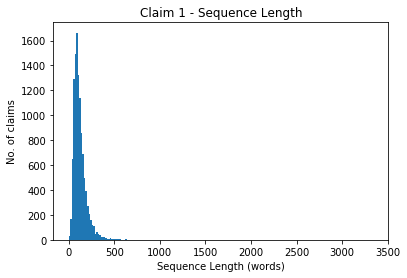

In [41]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

X_length = [len(x) for x in X_seqs]
max_length = max(X_length)
print("Our longest sequence is {0} tokens long.".format(max_length))

bins = np.linspace(0, max_length, 200)
plt.hist(X_length, bins)
plt.title('Claim 1 - Sequence Length')
plt.ylabel('No. of claims');
plt.xlabel('Sequence Length (words)');

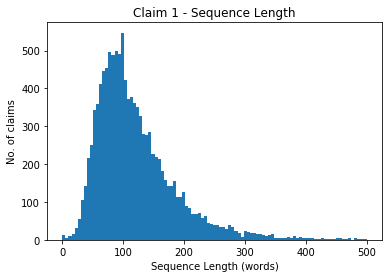

In [42]:
# Let's zoom in on 0 to 500
bins = np.linspace(0, 500, 100)
plt.hist(X_length, bins)
plt.title('Claim 1 - Sequence Length')
plt.ylabel('No. of claims');
plt.xlabel('Sequence Length (words)');

Let's limit our sequence length to 300 on our input.

Our longest sequence is 398 tokens long.


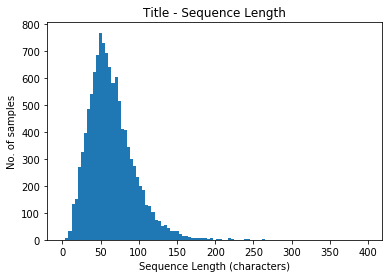

In [44]:
Y_length = [len(y) for y in Y_seqs]
max_y_length = max(Y_length)
print("Our longest sequence is {0} tokens long.".format(max_y_length))

bins = np.linspace(0, max_y_length, 100)
plt.hist(Y_length, bins)
plt.title('Title - Sequence Length')
plt.ylabel('No. of samples');
plt.xlabel('Sequence Length (characters)');

Let's limit to 150 on our output.  

So we can pad our input and output sequences, limiting to 300 on the input and 150 on the output.

In [45]:
from keras.preprocessing.sequence import pad_sequences

X = pad_sequences(X_seqs, maxlen=300)
Y = pad_sequences(Y_seqs, maxlen=150)

In [46]:
print("Our X data has shape {0} and our Y data has shape {1}".format(X.shape, Y.shape))

Our X data has shape (11428, 300) and our Y data has shape (11428, 150)


## Building the Sequence to Sequence Model

In [49]:
# Some hyperparameters - start with those used in this example -
# https://github.com/fchollet/keras/blob/master/examples/lstm_seq2seq.py
batch_size = 64  # Batch size for training.
epochs = 20  # Number of epochs to train for.

# The number of encoder tokens - we have limited our vocabulary to 10000
X_vocab_len = 10000 
X_max_len = 300
# We limit our decoder to a vocabulary of 5000
y_vocab_len = 34
y_max_len = 150

hidden_size = 100 # Latent dimensionality of the encoding space.
num_layers = 1

This blog post - https://chunml.github.io/ChunML.github.io/project/Sequence-To-Sequence/ and the code here - https://github.com/ChunML/seq2seq/blob/master/seq2seq_utils.py is useful for a word level seq2seq model.  

We can have the input as integers but we need the decoder output (i.e. our Y) as one-hot encoding. Using a character model and teacher forcing we want two Ys in one hot form, the second shifted forward in time.  

*** Aside *** It seems very inefficient to create two tensors to do this.

In [62]:
def to_one_hot(input_seqs, seq_max_len, vocab_len):
    """ Convert a sequence of integers to a sequence of one-hot vectors."""
    one_hot_in = np.zeros((len(input_seqs), seq_max_len, vocab_len))
    one_hot_out = np.zeros((len(input_seqs), seq_max_len, vocab_len))
    for i, sequence in enumerate(input_seqs):
        for t, word_int in enumerate(sequence):
            one_hot_in[i, t, word_int] = 1
            if t > 0:
                # Shift decoder target get so it is one ahead
                one_hot_out[i, t-1, word_int] = 1
    return one_hot_in, one_hot_out

We get a memory error when we try to create a complete Y_one_hot matrix. As per the above blogpost we can chop into blocks of 1000 for training.

In [63]:
Y_one_hot_in, Y_one_hot_out = to_one_hot(Y, y_max_len, y_vocab_len)

Checkout here for help: https://keras.io/getting-started/functional-api-guide/

In [59]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding

# Define an input sequence and process it.
inputs = Input(shape=(X_max_len,), dtype='int32', name='main_input')
embedding = Embedding(input_dim=X_vocab_len, output_dim=1000, input_length=X_max_len, mask_zero=True)(inputs)
encoder_outputs, state_h, state_c = LSTM(hidden_size, return_state=True)(embedding)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, y_vocab_len))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(y_vocab_len, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([inputs, decoder_inputs], decoder_outputs)

In [60]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 300)           0                                            
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 300, 1000)     10000000    main_input[0][0]                 
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, None, 34)      0                                            
____________________________________________________________________________________________________
lstm_7 (LSTM)                    [(None, 100), (None,  440400      embedding_7[0][0]                
___________________________________________________________________________________________

In [61]:
Y_one_hot.shape

(11428, 150, 34)

In [64]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
model.fit([X, Y_one_hot_in], Y_one_hot_out,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2
          )
# Save model
model.save('word2char.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 300)           0                                            
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 300, 1000)     10000000    main_input[0][0]                 
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, None, 34)      0                                            
____________________________________________________________________________________________________
lstm_7 (LSTM)                    [(None, 100), (None,  440400      embedding_7[0][0]                
___________________________________________________________________________________________

Adapt to save model using checkpointing as per here: https://machinelearningmastery.com/check-point-deep-learning-models-keras/

In [ ]:
# Testing Code
X_test = load_test_data('test', X_word_to_ix, MAX_LEN)
X_test = pad_sequences(X_test, maxlen=X_max_len, dtype='int32')
model.load_weights(saved_weights)
            
predictions = np.argmax(model.predict(X_test), axis=2)
sequences = []
for prediction in predictions:
    sequence = ' '.join([y_ix_to_word(index) for index in prediction if index > 0])
    print(sequence)
    sequences.append(sequence)
np.savetxt('test_result', sequences, fmt='%s')